## Install the package dependencies before running this notebook

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import lstm_encoder_decoder_no_early

In [3]:
import time
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- val: 43544 test: 6361
    # dearborn -- val: 24465 test: 3671
    # washington-dc -- val: 25744 test: 3829
    # palo-alto -- val:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [4]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "../../argo2/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "val", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    outputs = None
    
    if split == "train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)
        
    
    elif split == 'test':
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)
        
    else:
        print('\"split\" should be train, val, or test.')
        inputs = None

    return inputs, outputs

class ArgoverseDataset(Dataset):
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.split = split
        self.input_positions, self.output_positions = get_city_trajectories(city=city, split=split, normalized=False)
        
        self.input_positions = torch.Tensor(self.input_positions)
        num_inputs, input_seq_len = self.input_positions.shape[:2]
        self.center_input = (
            np.repeat(self.input_positions[:, 0, :], input_seq_len, axis=0)
            .reshape(num_inputs, input_seq_len, 2)
        )
        self.center = (
            np.repeat(self.input_positions[:, 0, :], 60, axis=0)
            .reshape(num_inputs, 120)
        )
        
        self.input_positions_centered = torch.Tensor(self.input_positions - self.center_input)
        self.input_velocities = torch.Tensor(np.diff(self.input_positions, axis=1))
        
        self.nn_pos_inputs = self.input_positions_centered
        self.nn_velo_inputs = self.input_velocities
        
        if split != 'test': 
            self.output_positions = torch.Tensor(self.output_positions)
            num_outputs, output_seq_len = self.output_positions.shape[:2]
            center_output = (
                np.repeat(self.input_positions[:, 0, :], output_seq_len, axis=0)
                .reshape(num_outputs, output_seq_len, 2)
            )
            self.output_positions_centered = torch.Tensor(self.output_positions - center_output)
            self.output_velocities = torch.Tensor(np.diff(self.output_positions, axis=1))
                    
            self.nn_pos_outputs = self.output_positions_centered[:, 0, :].unsqueeze(1)
            self.nn_velo_outputs = self.output_velocities

    def __len__(self):
        return len(self.nn_pos_inputs)

    def __getitem__(self, idx):
        if self.split != 'test':
            data = (
                self.nn_pos_inputs[idx], 
                self.nn_pos_outputs[idx], 
                self.nn_velo_inputs[idx], 
                self.nn_velo_outputs[idx],
                self.input_positions[idx],
                self.output_positions[idx],
                self.input_positions_centered[idx],
                self.output_positions_centered[idx]
            )
        else:
            data = data = (
                self.nn_pos_inputs[idx], 
                self.nn_velo_inputs[idx], 
                self.center[idx]
            )
        return data

In [5]:
!nvidia-smi

Sat May 28 01:30:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.77       Driver Version: 512.77       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 58%   47C    P8    34W / 370W |   6921MiB / 12288MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
# train_dataset = ArgoverseDataset('austin', 'train')
# val_dataset = ArgoverseDataset('austin', 'train')
# test_dataset = ArgoverseDataset('austin', 'test')

In [7]:
# for t in val_dataset.__getitem__(0):
#     print(t.shape)

In [8]:
# function that tells how long valing takes
def val_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Training austin


100%|██████████| 30/30 [00:36<00:00,  1.23s/it, loss=0.32627] 


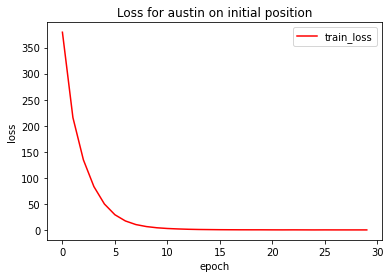

100%|██████████| 80/80 [21:50<00:00, 16.38s/it, loss=0.00193]


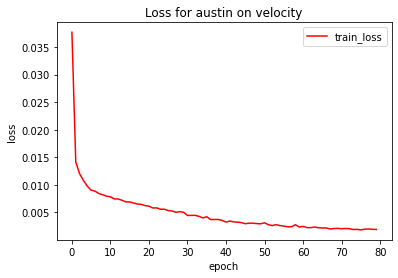

Total training time is: 22m 29s for austin
Training miami


100%|██████████| 30/30 [01:17<00:00,  2.59s/it, loss=0.19150] 


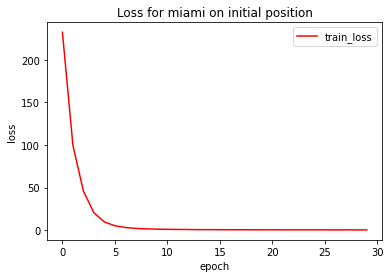

100%|██████████| 80/80 [24:25<00:00, 18.32s/it, loss=0.00136]


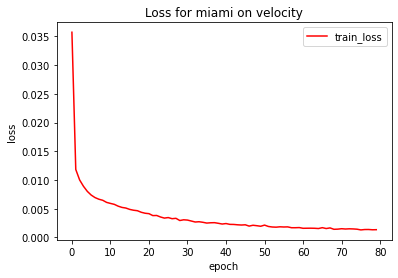

Total training time is: 25m 43s for miami
Training pittsburgh


100%|██████████| 30/30 [00:46<00:00,  1.56s/it, loss=0.33162] 


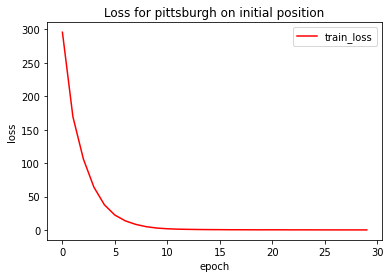

100%|██████████| 80/80 [23:35<00:00, 17.69s/it, loss=0.00170]


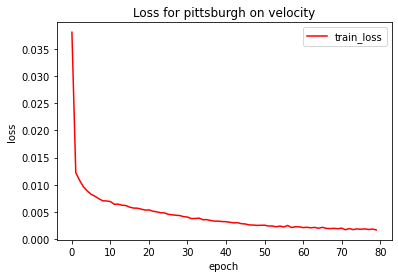

Total training time is: 24m 22s for pittsburgh
Training dearborn


100%|██████████| 30/30 [00:35<00:00,  1.18s/it, loss=0.89942] 


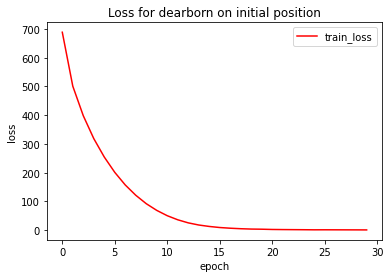

100%|██████████| 80/80 [13:34<00:00, 10.18s/it, loss=0.00484]


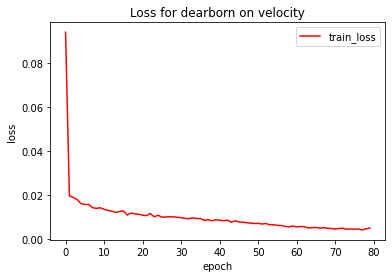

Total training time is: 14m 10s for dearborn
Training washington-dc


100%|██████████| 30/30 [00:20<00:00,  1.45it/s, loss=0.43777] 


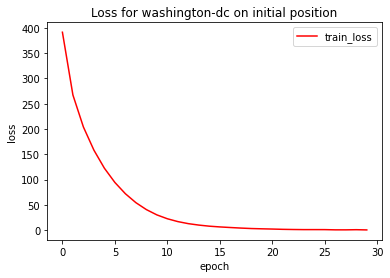

100%|██████████| 80/80 [08:03<00:00,  6.04s/it, loss=0.00315]


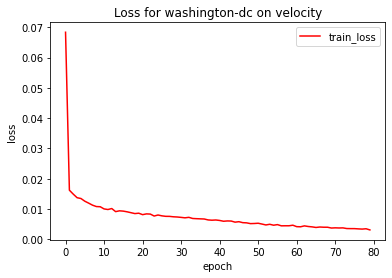

Total training time is: 8m 24s for washington-dc
Training palo-alto


100%|██████████| 30/30 [00:10<00:00,  2.98it/s, loss=32.93519] 


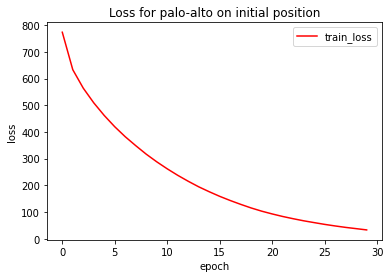

100%|██████████| 80/80 [03:42<00:00,  2.78s/it, loss=0.00827]


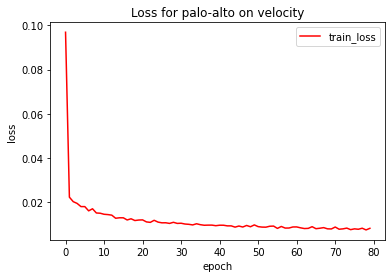

Total training time is: 3m 52s for palo-alto
CPU times: total: 49min 1s
Wall time: 1h 39min 3s


In [9]:
%%time

# train one model for each city
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for city in cities:
    print('Training ' + str(city))
    train_dataset = ArgoverseDataset(city, 'train')

    X_train_nn_pos = train_dataset.nn_pos_inputs.to(device)
    y_train_nn_pos = train_dataset.nn_pos_outputs.to(device)
    X_train_nn_velo = train_dataset.nn_velo_inputs.to(device)
    y_train_nn_velo = train_dataset.nn_velo_outputs.to(device)
    X_train = train_dataset.input_positions.to(device)
    y_train = train_dataset.output_positions.to(device)

    start_time = time.time()
    nn_pos = lstm_encoder_decoder_no_early.lstm_seq2seq(
        input_size=2,
        hidden_size=64,
        num_layers=2,
        dropout=0.3
    )

    nn_pos.to(device)

    train_losses_pos = lstm_encoder_decoder_no_early.train_model(
        nn_pos,
        city,
        X_train_nn_pos,
        y_train_nn_pos,
        n_epochs=30,
        target_len=1,
        batch_size=256,
        training_prediction='mixed_teacher_forcing',
        teacher_forcing_ratio=0.6,
        learning_rate=0.001,
        dynamic_tf=False,
        device=device
    )

    pickle.dump(nn_pos, open('../models/seq2seq_lstm_pos_' + str(nn_pos.num_layers) + '_' + city, 'wb'))
    plt.title("Loss for " + city + " on initial position")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(train_losses_pos, color="red", label="train_loss")
    plt.legend()
    plt.show()


    nn_velo = lstm_encoder_decoder_no_early.lstm_seq2seq(
        input_size=2,
        hidden_size=256,
        num_layers=3,
        dropout=0.3
    )

    nn_velo.to(device)

    train_losses_velo = lstm_encoder_decoder_no_early.train_model(
        nn_velo,
        city,
        X_train_nn_velo,
        y_train_nn_velo,
        n_epochs=80,
        target_len=59,
        batch_size=256,
        training_prediction='mixed_teacher_forcing',
        teacher_forcing_ratio=0.6,
        learning_rate=0.0001,
        dynamic_tf=False,
        device=device
    )

    pickle.dump(nn_velo, open('../models/seq2seq_lstm_velo_' + str(nn_velo.num_layers) + '_' + city, 'wb'))
    plt.title("Loss for " + city + " on velocity")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(train_losses_velo, color="red", label="train_loss")
    plt.legend()
    plt.show()

    end_time = time.time()
    train_mins, train_secs = train_time(start_time, end_time)
    print(
        f'Total training time is: {train_mins}m {train_secs}s' + ' for ' + city)




### Check final validation loss (bad runtime now for sequential ingestion of data)

In [10]:
# nn_pos.eval()
# nn_velo.eval()

# total_loss = 0
# for n in range(val_dataset.__len__()):
#     nn_pos_nth_input, nn_pos_nth_output, nn_velo_nth_input, nn_velo_nth_output, _, _, _, nth_output_centered = val_dataset.__getitem__(
#         n)

#     nn_pos_nth_input = nn_pos_nth_input.to(device)
#     nn_pos_nth_output = nn_pos_nth_output.to(device)
#     nn_velo_nth_input = nn_velo_nth_input.to(device)
#     nn_velo_nth_output = nn_velo_nth_output.to(device)
#     nth_output_centered = nth_output_centered.to(device)

#     init_pos = lstm_encoder_decoder_no_early.predict(nn_pos, nn_pos_nth_input, 1, device=device)
#     deltas = lstm_encoder_decoder_no_early.predict(nn_velo, nn_velo_nth_input, 59, device=device)
#     total_loss += ((torch.cumsum(torch.cat((init_pos, deltas)),
#                     dim=0) - nth_output_centered) ** 2).mean()

# valid_loss = total_loss / val_dataset.__len__()

# print("Final validation loss is: " + str(valid_loss) + " for " + city)


### Generate CSV

In [11]:
nn_pos.eval()
nn_velo.eval()
num_layers_pos = 2
num_layers_velo = 3

all_preds = []
for city in cities:
    test_dataset = ArgoverseDataset(city=city, split='test')
    rows = []
    model_pos = pickle.load(open('../models/seq2seq_lstm_pos_' + str(num_layers_pos) + '_' + city, 'rb'))
    model_velo = pickle.load(open('../models/seq2seq_lstm_velo_' + str(num_layers_velo) + '_' + city, 'rb'))
    for n in range(test_dataset.__len__()):
        if n % 1_000 == 0 and n > 0: 
            print(str(n) + ' predictions for ' + str(city) + ' completed.')
        nn_pos_nth_input, nn_velo_nth_input, center_input = test_dataset.__getitem__(n)
        nn_pos_nth_input = nn_pos_nth_input.to(device)
        nn_velo_nth_input = nn_velo_nth_input.to(device)
        center_input = center_input.to(device)
        init_pos = lstm_encoder_decoder_no_early.predict(model_pos, nn_pos_nth_input, 1, device=device)
        deltas = lstm_encoder_decoder_no_early.predict(model_velo, nn_velo_nth_input, 59, device=device)

        pred = (torch.cumsum(torch.cat((init_pos, deltas)), dim=0).flatten() + center_input).cpu().numpy()
        rows.append(pred)
    ids = np.array([str(i) + '_' + city for i in range(len(rows))])
    cols = np.array(['v' + str(i) for i in range(120)])
    predictions = pd.DataFrame(rows, columns=cols)
    predictions.insert(0, 'ID', ids)
    all_preds.append(predictions)
all_predictions = pd.concat(all_preds, ignore_index=True)

1000 predictions for austin completed.
2000 predictions for austin completed.
3000 predictions for austin completed.
4000 predictions for austin completed.
5000 predictions for austin completed.
6000 predictions for austin completed.
1000 predictions for miami completed.
2000 predictions for miami completed.
3000 predictions for miami completed.
4000 predictions for miami completed.
5000 predictions for miami completed.
6000 predictions for miami completed.
7000 predictions for miami completed.
1000 predictions for pittsburgh completed.
2000 predictions for pittsburgh completed.
3000 predictions for pittsburgh completed.
4000 predictions for pittsburgh completed.
5000 predictions for pittsburgh completed.
6000 predictions for pittsburgh completed.
1000 predictions for dearborn completed.
2000 predictions for dearborn completed.
3000 predictions for dearborn completed.
1000 predictions for washington-dc completed.
2000 predictions for washington-dc completed.
3000 predictions for washin

In [12]:
all_predictions.to_csv('two_lstm_enc_dec_out.csv', index=False)

Training austin


100%|██████████| 30/30 [00:51<00:00,  1.71s/it, loss=0.52265] 


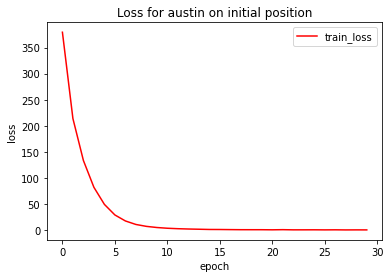

100%|██████████| 80/80 [10:25<00:00,  7.82s/it, loss=0.00162]


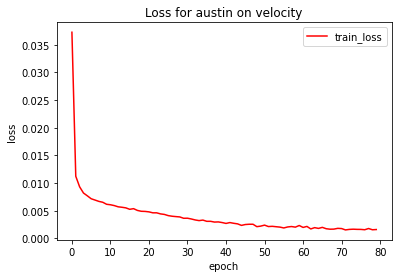

Total training time is: 11m 17s for austin
Training miami


100%|██████████| 30/30 [01:05<00:00,  2.18s/it, loss=0.30711] 


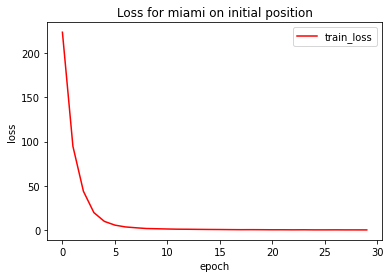

100%|██████████| 80/80 [13:14<00:00,  9.94s/it, loss=0.00114]


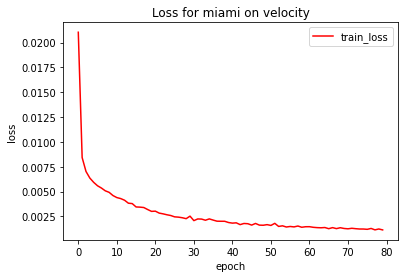

Total training time is: 14m 20s for miami
Training pittsburgh


100%|██████████| 30/30 [00:52<00:00,  1.74s/it, loss=0.45942] 


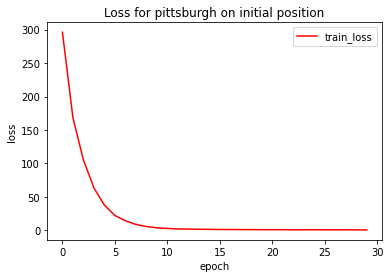

100%|██████████| 80/80 [10:36<00:00,  7.96s/it, loss=0.00162]


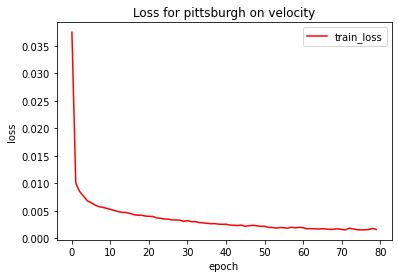

Total training time is: 11m 29s for pittsburgh
Training dearborn


100%|██████████| 30/30 [00:28<00:00,  1.05it/s, loss=1.45818] 


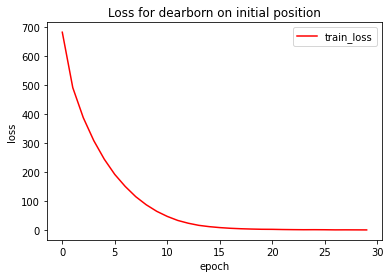

100%|██████████| 80/80 [05:56<00:00,  4.46s/it, loss=0.00369]


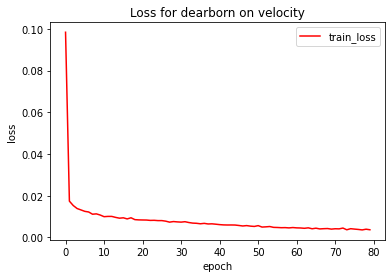

Total training time is: 6m 25s for dearborn
Training washington-dc


100%|██████████| 30/30 [00:31<00:00,  1.06s/it, loss=0.90792] 


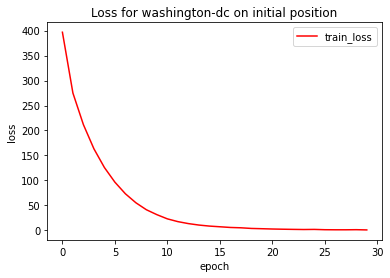

100%|██████████| 80/80 [06:10<00:00,  4.63s/it, loss=0.00309]


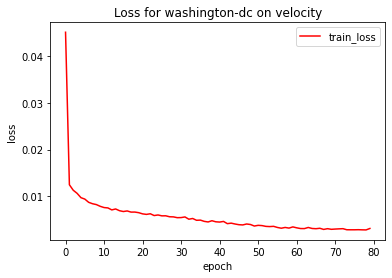

Total training time is: 6m 42s for washington-dc
Training palo-alto


100%|██████████| 30/30 [00:14<00:00,  2.10it/s, loss=34.53060] 


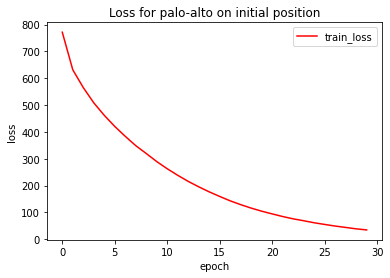

100%|██████████| 80/80 [02:49<00:00,  2.11s/it, loss=0.00570]


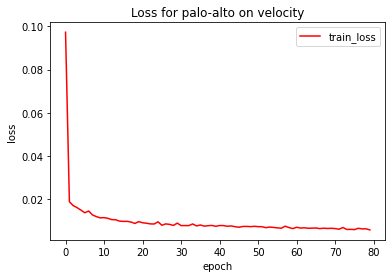

Total training time is: 3m 3s for palo-alto
CPU times: total: 11min 38s
Wall time: 53min 18s


In [13]:
%%time

# train one model for each city
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for city in cities:
    print('Training ' + str(city))
    train_dataset = ArgoverseDataset(city, 'train')

    X_train_nn_pos = train_dataset.nn_pos_inputs.to(device)
    y_train_nn_pos = train_dataset.nn_pos_outputs.to(device)
    X_train_nn_velo = train_dataset.nn_velo_inputs.to(device)
    y_train_nn_velo = train_dataset.nn_velo_outputs.to(device)
    X_train = train_dataset.input_positions.to(device)
    y_train = train_dataset.output_positions.to(device)

    start_time = time.time()
    nn_pos = lstm_encoder_decoder_no_early.lstm_seq2seq(
        input_size=2,
        hidden_size=64,
        num_layers=3,
        dropout=0.3
    )

    nn_pos.to(device)

    train_losses_pos = lstm_encoder_decoder_no_early.train_model(
        nn_pos,
        city,
        X_train_nn_pos,
        y_train_nn_pos,
        n_epochs=30,
        target_len=1,
        batch_size=256,
        training_prediction='mixed_teacher_forcing',
        teacher_forcing_ratio=0.6,
        learning_rate=0.001,
        dynamic_tf=False,
        device=device
    )

    pickle.dump(nn_pos, open('../models/seq2seq_lstm_pos_' + str(nn_pos.num_layers) + '_' + city, 'wb'))
    plt.title("Loss for " + city + " on initial position")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(train_losses_pos, color="red", label="train_loss")
    plt.legend()
    plt.show()


    nn_velo = lstm_encoder_decoder_no_early.lstm_seq2seq(
        input_size=2,
        hidden_size=256,
        num_layers=2,
        dropout=0.3
    )

    nn_velo.to(device)

    train_losses_velo = lstm_encoder_decoder_no_early.train_model(
        nn_velo,
        city,
        X_train_nn_velo,
        y_train_nn_velo,
        n_epochs=80,
        target_len=59,
        batch_size=256,
        training_prediction='mixed_teacher_forcing',
        teacher_forcing_ratio=0.6,
        learning_rate=0.0001,
        dynamic_tf=False,
        device=device
    )

    pickle.dump(nn_velo, open('../models/seq2seq_lstm_velo_' + str(nn_velo.num_layers) + '_' + city, 'wb'))
    plt.title("Loss for " + city + " on velocity")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(train_losses_velo, color="red", label="train_loss")
    plt.legend()
    plt.show()

    end_time = time.time()
    train_mins, train_secs = train_time(start_time, end_time)
    print(
        f'Total training time is: {train_mins}m {train_secs}s' + ' for ' + city)

In [14]:
nn_pos.eval()
nn_velo.eval()
num_layers_pos = 3
num_layers_velo = 2

all_preds = []
for city in cities:
    test_dataset = ArgoverseDataset(city=city, split='test')
    rows = []
    model_pos = pickle.load(open('../models/seq2seq_lstm_pos_' + str(num_layers_pos) + '_' + city, 'rb'))
    model_velo = pickle.load(open('../models/seq2seq_lstm_velo_' + str(num_layers_velo) + '_' + city, 'rb'))
    for n in range(test_dataset.__len__()):
        if n % 1_000 == 0 and n > 0: 
            print(str(n) + ' predictions for ' + str(city) + ' completed.')
        nn_pos_nth_input, nn_velo_nth_input, center_input = test_dataset.__getitem__(n)
        nn_pos_nth_input = nn_pos_nth_input.to(device)
        nn_velo_nth_input = nn_velo_nth_input.to(device)
        center_input = center_input.to(device)
        init_pos = lstm_encoder_decoder_no_early.predict(model_pos, nn_pos_nth_input, 1, device=device)
        deltas = lstm_encoder_decoder_no_early.predict(model_velo, nn_velo_nth_input, 59, device=device)

        pred = (torch.cumsum(torch.cat((init_pos, deltas)), dim=0).flatten() + center_input).cpu().numpy()
        rows.append(pred)
    ids = np.array([str(i) + '_' + city for i in range(len(rows))])
    cols = np.array(['v' + str(i) for i in range(120)])
    predictions = pd.DataFrame(rows, columns=cols)
    predictions.insert(0, 'ID', ids)
    all_preds.append(predictions)
all_predictions = pd.concat(all_preds, ignore_index=True)

1000 predictions for austin completed.
2000 predictions for austin completed.
3000 predictions for austin completed.
4000 predictions for austin completed.
5000 predictions for austin completed.
6000 predictions for austin completed.
1000 predictions for miami completed.
2000 predictions for miami completed.
3000 predictions for miami completed.
4000 predictions for miami completed.
5000 predictions for miami completed.
6000 predictions for miami completed.
7000 predictions for miami completed.
1000 predictions for pittsburgh completed.
2000 predictions for pittsburgh completed.
3000 predictions for pittsburgh completed.
4000 predictions for pittsburgh completed.
5000 predictions for pittsburgh completed.
6000 predictions for pittsburgh completed.
1000 predictions for dearborn completed.
2000 predictions for dearborn completed.
3000 predictions for dearborn completed.
1000 predictions for washington-dc completed.
2000 predictions for washington-dc completed.
3000 predictions for washin

In [15]:
all_predictions.to_csv('two_lstm_enc_dec_out_2.csv', index=False)

Training austin


100%|██████████| 50/50 [00:31<00:00,  1.58it/s, loss=0.09926] 


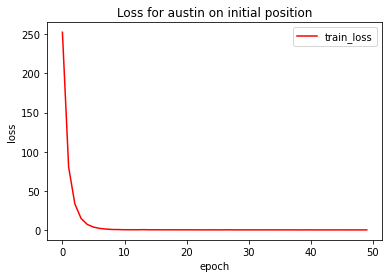

100%|██████████| 100/100 [09:41<00:00,  5.81s/it, loss=0.00091]


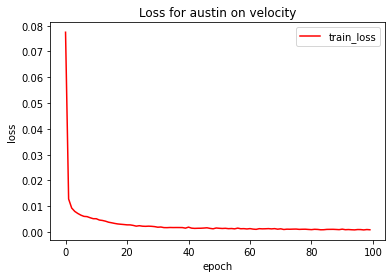

Total training time is: 10m 13s for austin
Training miami


100%|██████████| 50/50 [00:39<00:00,  1.28it/s, loss=0.05036] 


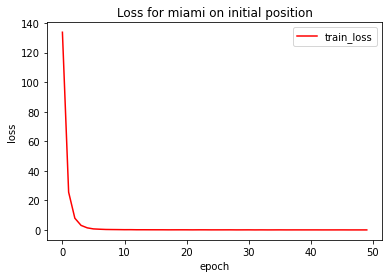

100%|██████████| 100/100 [12:19<00:00,  7.40s/it, loss=0.00057]


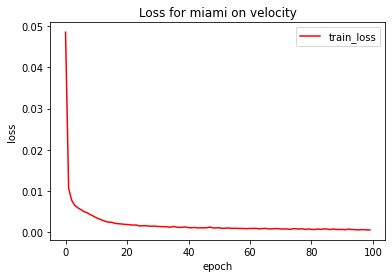

Total training time is: 12m 59s for miami
Training pittsburgh


100%|██████████| 50/50 [00:31<00:00,  1.59it/s, loss=0.06821] 


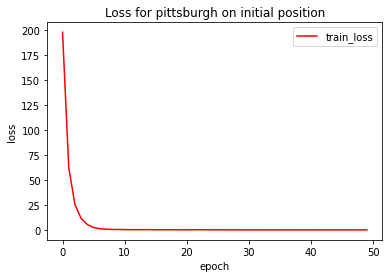

100%|██████████| 100/100 [09:46<00:00,  5.87s/it, loss=0.00077]


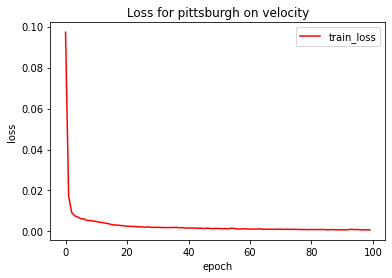

Total training time is: 10m 18s for pittsburgh
Training dearborn


100%|██████████| 50/50 [00:17<00:00,  2.90it/s, loss=0.20959] 


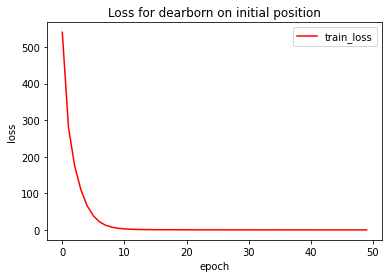

100%|██████████| 100/100 [05:29<00:00,  3.29s/it, loss=0.00215]


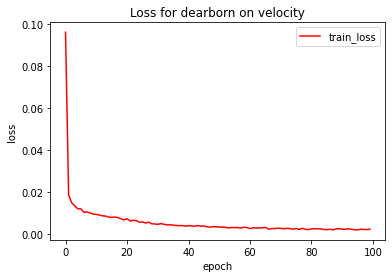

Total training time is: 5m 46s for dearborn
Training washington-dc


100%|██████████| 50/50 [00:18<00:00,  2.68it/s, loss=0.08502] 


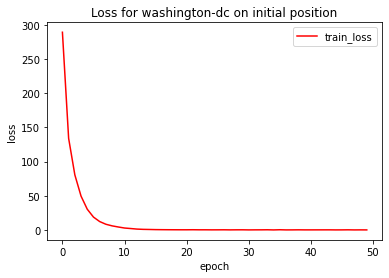

100%|██████████| 100/100 [05:46<00:00,  3.46s/it, loss=0.00168]


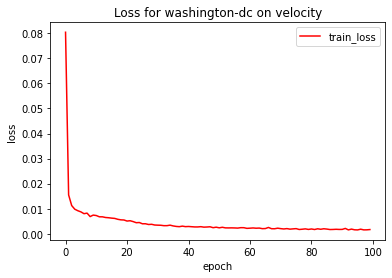

Total training time is: 6m 5s for washington-dc
Training palo-alto


100%|██████████| 50/50 [00:08<00:00,  5.69it/s, loss=0.33170] 


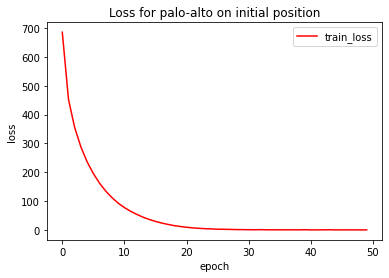

100%|██████████| 100/100 [02:38<00:00,  1.58s/it, loss=0.00247]


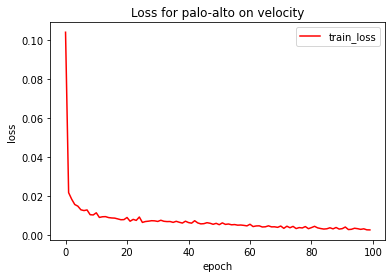

Total training time is: 2m 47s for palo-alto
CPU times: total: 7min 41s
Wall time: 48min 9s


In [17]:
%%time

# train one model for each city
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for city in cities:
    print('Training ' + str(city))
    train_dataset = ArgoverseDataset(city, 'train')

    X_train_nn_pos = train_dataset.nn_pos_inputs.to(device)
    y_train_nn_pos = train_dataset.nn_pos_outputs.to(device)
    X_train_nn_velo = train_dataset.nn_velo_inputs.to(device)
    y_train_nn_velo = train_dataset.nn_velo_outputs.to(device)
    X_train = train_dataset.input_positions.to(device)
    y_train = train_dataset.output_positions.to(device)

    start_time = time.time()
    nn_pos = lstm_encoder_decoder_no_early.lstm_seq2seq(
        input_size=2,
        hidden_size=128,
        num_layers=1,
        dropout=0.3
    )

    nn_pos.to(device)

    train_losses_pos = lstm_encoder_decoder_no_early.train_model(
        nn_pos,
        city,
        X_train_nn_pos,
        y_train_nn_pos,
        n_epochs=50,
        target_len=1,
        batch_size=256,
        training_prediction='mixed_teacher_forcing',
        teacher_forcing_ratio=0.6,
        learning_rate=0.001,
        dynamic_tf=False,
        device=device
    )

    pickle.dump(nn_pos, open('../models/seq2seq_lstm_pos_' + str(nn_pos.num_layers) + '_' + city, 'wb'))
    plt.title("Loss for " + city + " on initial position")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(train_losses_pos, color="red", label="train_loss")
    plt.legend()
    plt.show()


    nn_velo = lstm_encoder_decoder_no_early.lstm_seq2seq(
        input_size=2,
        hidden_size=512,
        num_layers=1,
        dropout=0.3
    )

    nn_velo.to(device)

    train_losses_velo = lstm_encoder_decoder_no_early.train_model(
        nn_velo,
        city,
        X_train_nn_velo,
        y_train_nn_velo,
        n_epochs=100,
        target_len=59,
        batch_size=256,
        training_prediction='mixed_teacher_forcing',
        teacher_forcing_ratio=0.6,
        learning_rate=0.0001,
        dynamic_tf=False,
        device=device
    )

    pickle.dump(nn_velo, open('../models/seq2seq_lstm_velo_' + str(nn_velo.num_layers) + '_' + city, 'wb'))
    plt.title("Loss for " + city + " on velocity")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(train_losses_velo, color="red", label="train_loss")
    plt.legend()
    plt.show()

    end_time = time.time()
    train_mins, train_secs = train_time(start_time, end_time)
    print(
        f'Total training time is: {train_mins}m {train_secs}s' + ' for ' + city)

In [18]:
nn_pos.eval()
nn_velo.eval()
num_layers_pos = 1
num_layers_velo = 1

all_preds = []
for city in cities:
    test_dataset = ArgoverseDataset(city=city, split='test')
    rows = []
    model_pos = pickle.load(open('../models/seq2seq_lstm_pos_' + str(num_layers_pos) + '_' + city, 'rb'))
    model_velo = pickle.load(open('../models/seq2seq_lstm_velo_' + str(num_layers_velo) + '_' + city, 'rb'))
    for n in range(test_dataset.__len__()):
        if n % 1_000 == 0 and n > 0: 
            print(str(n) + ' predictions for ' + str(city) + ' completed.')
        nn_pos_nth_input, nn_velo_nth_input, center_input = test_dataset.__getitem__(n)
        nn_pos_nth_input = nn_pos_nth_input.to(device)
        nn_velo_nth_input = nn_velo_nth_input.to(device)
        center_input = center_input.to(device)
        init_pos = lstm_encoder_decoder_no_early.predict(model_pos, nn_pos_nth_input, 1, device=device)
        deltas = lstm_encoder_decoder_no_early.predict(model_velo, nn_velo_nth_input, 59, device=device)

        pred = (torch.cumsum(torch.cat((init_pos, deltas)), dim=0).flatten() + center_input).cpu().numpy()
        rows.append(pred)
    ids = np.array([str(i) + '_' + city for i in range(len(rows))])
    cols = np.array(['v' + str(i) for i in range(120)])
    predictions = pd.DataFrame(rows, columns=cols)
    predictions.insert(0, 'ID', ids)
    all_preds.append(predictions)
all_predictions = pd.concat(all_preds, ignore_index=True)

1000 predictions for austin completed.
2000 predictions for austin completed.
3000 predictions for austin completed.
4000 predictions for austin completed.
5000 predictions for austin completed.
6000 predictions for austin completed.
1000 predictions for miami completed.
2000 predictions for miami completed.
3000 predictions for miami completed.
4000 predictions for miami completed.
5000 predictions for miami completed.
6000 predictions for miami completed.
7000 predictions for miami completed.
1000 predictions for pittsburgh completed.
2000 predictions for pittsburgh completed.
3000 predictions for pittsburgh completed.
4000 predictions for pittsburgh completed.
5000 predictions for pittsburgh completed.
6000 predictions for pittsburgh completed.
1000 predictions for dearborn completed.
2000 predictions for dearborn completed.
3000 predictions for dearborn completed.
1000 predictions for washington-dc completed.
2000 predictions for washington-dc completed.
3000 predictions for washin

In [19]:
all_predictions.to_csv('two_lstm_enc_dec_out_3.csv', index=False)

Training austin


100%|██████████| 50/50 [01:20<00:00,  1.61s/it, loss=0.08364] 


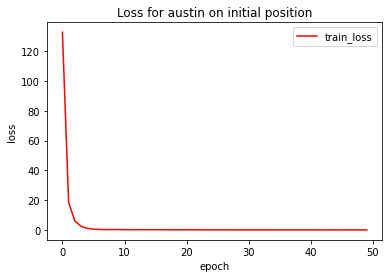

100%|██████████| 100/100 [23:16<00:00, 13.97s/it, loss=0.00116]


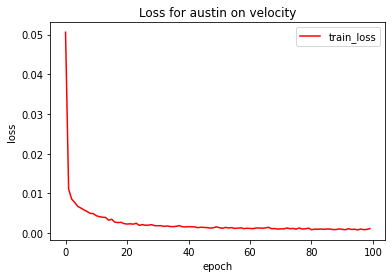

Total training time is: 24m 37s for austin
Training miami


100%|██████████| 50/50 [01:15<00:00,  1.51s/it, loss=0.06551]


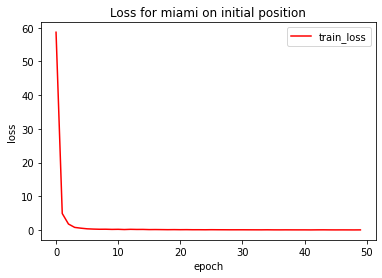

100%|██████████| 100/100 [30:25<00:00, 18.25s/it, loss=0.00055]


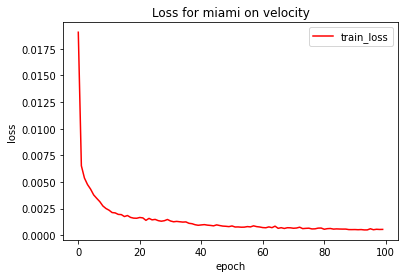

Total training time is: 31m 41s for miami
Training pittsburgh


100%|██████████| 50/50 [01:32<00:00,  1.85s/it, loss=0.10025] 


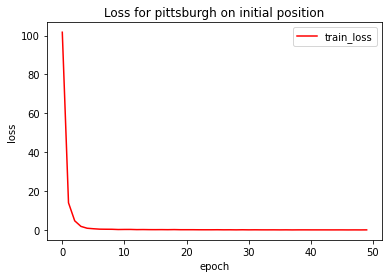

100%|██████████| 100/100 [24:53<00:00, 14.93s/it, loss=0.00087]


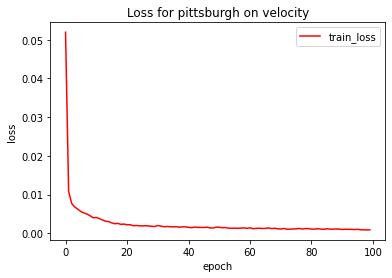

Total training time is: 26m 25s for pittsburgh
Training dearborn


100%|██████████| 50/50 [00:51<00:00,  1.04s/it, loss=0.18646] 


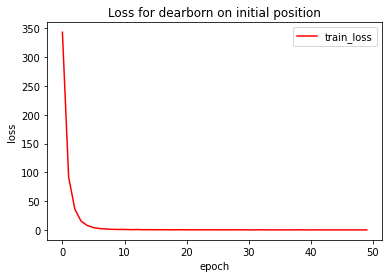

100%|██████████| 100/100 [13:23<00:00,  8.03s/it, loss=0.00202]


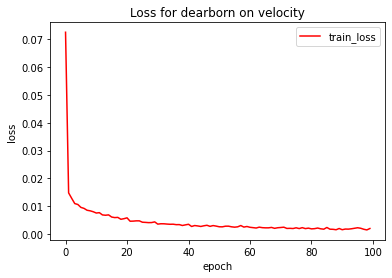

Total training time is: 14m 15s for dearborn
Training washington-dc


100%|██████████| 50/50 [00:56<00:00,  1.12s/it, loss=0.12091] 


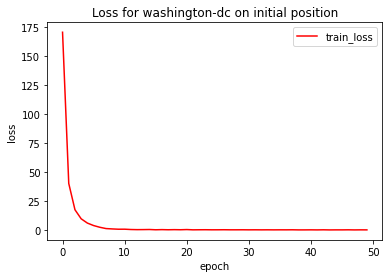

100%|██████████| 100/100 [14:31<00:00,  8.72s/it, loss=0.00160]


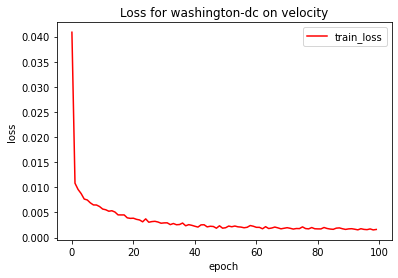

Total training time is: 15m 28s for washington-dc
Training palo-alto


100%|██████████| 50/50 [00:23<00:00,  2.14it/s, loss=0.84015] 


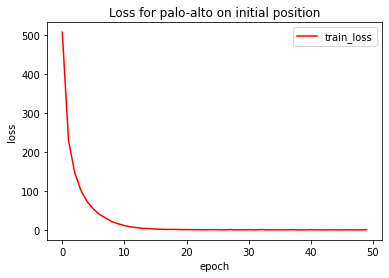

100%|██████████| 100/100 [06:11<00:00,  3.71s/it, loss=0.00259]


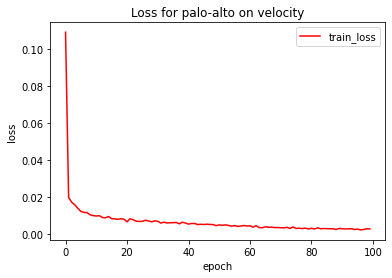

Total training time is: 6m 35s for palo-alto
CPU times: total: 1h 8min 33s
Wall time: 1h 59min 4s


In [26]:
%%time

# train one model for each city
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for city in cities:
    print('Training ' + str(city))
    train_dataset = ArgoverseDataset(city, 'train')

    X_train_nn_pos = train_dataset.nn_pos_inputs.to(device)
    y_train_nn_pos = train_dataset.nn_pos_outputs.to(device)
    X_train_nn_velo = train_dataset.nn_velo_inputs.to(device)
    y_train_nn_velo = train_dataset.nn_velo_outputs.to(device)
    X_train = train_dataset.input_positions.to(device)
    y_train = train_dataset.output_positions.to(device)

    start_time = time.time()
    nn_pos = lstm_encoder_decoder_no_early.lstm_seq2seq(
        input_size=2,
        hidden_size=128,
        num_layers=1,
        dropout=0.3,
        bidirectional = True
    )

    nn_pos.to(device)

    train_losses_pos = lstm_encoder_decoder_no_early.train_model(
        nn_pos,
        city,
        X_train_nn_pos,
        y_train_nn_pos,
        n_epochs=50,
        target_len=1,
        batch_size=256,
        training_prediction='mixed_teacher_forcing',
        teacher_forcing_ratio=0.6,
        learning_rate=0.001,
        dynamic_tf=False,
        device=device
    )

    pickle.dump(nn_pos, open('../models/seq2seq_lstm_pos_bi_' + str(nn_pos.num_layers) + '_' + city, 'wb'))
    plt.title("Loss for " + city + " on initial position")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(train_losses_pos, color="red", label="train_loss")
    plt.legend()
    plt.show()


    nn_velo = lstm_encoder_decoder_no_early.lstm_seq2seq(
        input_size=2,
        hidden_size=512,
        num_layers=1,
        dropout=0.3,
        bidirectional = True
    )

    nn_velo.to(device)

    train_losses_velo = lstm_encoder_decoder_no_early.train_model(
        nn_velo,
        city,
        X_train_nn_velo,
        y_train_nn_velo,
        n_epochs=100,
        target_len=59,
        batch_size=256,
        training_prediction='mixed_teacher_forcing',
        teacher_forcing_ratio=0.6,
        learning_rate=0.0001,
        dynamic_tf=False,
        device=device
    )

    pickle.dump(nn_velo, open('../models/seq2seq_lstm_velo_bi_' + str(nn_velo.num_layers) + '_' + city, 'wb'))
    plt.title("Loss for " + city + " on velocity")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(train_losses_velo, color="red", label="train_loss")
    plt.legend()
    plt.show()

    end_time = time.time()
    train_mins, train_secs = train_time(start_time, end_time)
    print(
        f'Total training time is: {train_mins}m {train_secs}s' + ' for ' + city)

In [27]:
nn_pos.eval()
nn_velo.eval()
num_layers_pos = 1
num_layers_velo = 1

all_preds = []
for city in cities:
    test_dataset = ArgoverseDataset(city=city, split='test')
    rows = []
    model_pos = pickle.load(open('../models/seq2seq_lstm_pos_bi_' + str(num_layers_pos) + '_' + city, 'rb'))
    model_velo = pickle.load(open('../models/seq2seq_lstm_velo_bi_' + str(num_layers_velo) + '_' + city, 'rb'))
    for n in range(test_dataset.__len__()):
        if n % 1_000 == 0 and n > 0: 
            print(str(n) + ' predictions for ' + str(city) + ' completed.')
        nn_pos_nth_input, nn_velo_nth_input, center_input = test_dataset.__getitem__(n)
        nn_pos_nth_input = nn_pos_nth_input.to(device)
        nn_velo_nth_input = nn_velo_nth_input.to(device)
        center_input = center_input.to(device)
        init_pos = lstm_encoder_decoder_no_early.predict(model_pos, nn_pos_nth_input, 1, device=device)
        deltas = lstm_encoder_decoder_no_early.predict(model_velo, nn_velo_nth_input, 59, device=device)

        pred = (torch.cumsum(torch.cat((init_pos, deltas)), dim=0).flatten() + center_input).cpu().numpy()
        rows.append(pred)
    ids = np.array([str(i) + '_' + city for i in range(len(rows))])
    cols = np.array(['v' + str(i) for i in range(120)])
    predictions = pd.DataFrame(rows, columns=cols)
    predictions.insert(0, 'ID', ids)
    all_preds.append(predictions)
all_predictions = pd.concat(all_preds, ignore_index=True)

1000 predictions for austin completed.
2000 predictions for austin completed.
3000 predictions for austin completed.
4000 predictions for austin completed.
5000 predictions for austin completed.
6000 predictions for austin completed.
1000 predictions for miami completed.
2000 predictions for miami completed.
3000 predictions for miami completed.
4000 predictions for miami completed.
5000 predictions for miami completed.
6000 predictions for miami completed.
7000 predictions for miami completed.
1000 predictions for pittsburgh completed.
2000 predictions for pittsburgh completed.
3000 predictions for pittsburgh completed.
4000 predictions for pittsburgh completed.
5000 predictions for pittsburgh completed.
6000 predictions for pittsburgh completed.
1000 predictions for dearborn completed.
2000 predictions for dearborn completed.
3000 predictions for dearborn completed.
1000 predictions for washington-dc completed.
2000 predictions for washington-dc completed.
3000 predictions for washin

In [28]:
all_predictions.to_csv('two_lstm_enc_dec_out_4.csv', index=False)